<a href="https://colab.research.google.com/github/siliconshells/Explainable-AI/blob/main/week_5_explainable_techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## XAI - Explainable Techniques II
### Leonard Eshun
#### Instructions

For a model and dataset of your choice, produce PDP, ICE, and ALE plots. Exploratory analysis of your dataset should be performed to determine the amount of correlation between features.  

Provide a comprehensive explanation of your plots. Discuss any interesting findings that are shown in the plots. Discuss any differences you see in the PDP and ALE plots. Discuss your exploratory findings around correlation between features and the impact this has (if any) on your results.

#### Project      
Predicing the house price in California and checking explainability with PDP, ICE, and ALE plots.   

The California housing dataset contains information about various features of houses in California, such as median income, average house age, average number of rooms, average number of bedrooms, population, average occupancy, latitude, and longitude. The target variable is the median house value for each block group.      

The selected model is RandomForestRegressor.

In [2]:
!pip install PyALE

In [3]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score, mean_absolute_error

# Explainability
from PyALE import ale
from sklearn.inspection import PartialDependenceDisplay

np.random.seed(45)

### Load the data and define features and target variable.

In [4]:
data = fetch_california_housing(as_frame=True)
data = data.frame
print(data.info(), end="\n\n")

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Data Distributions

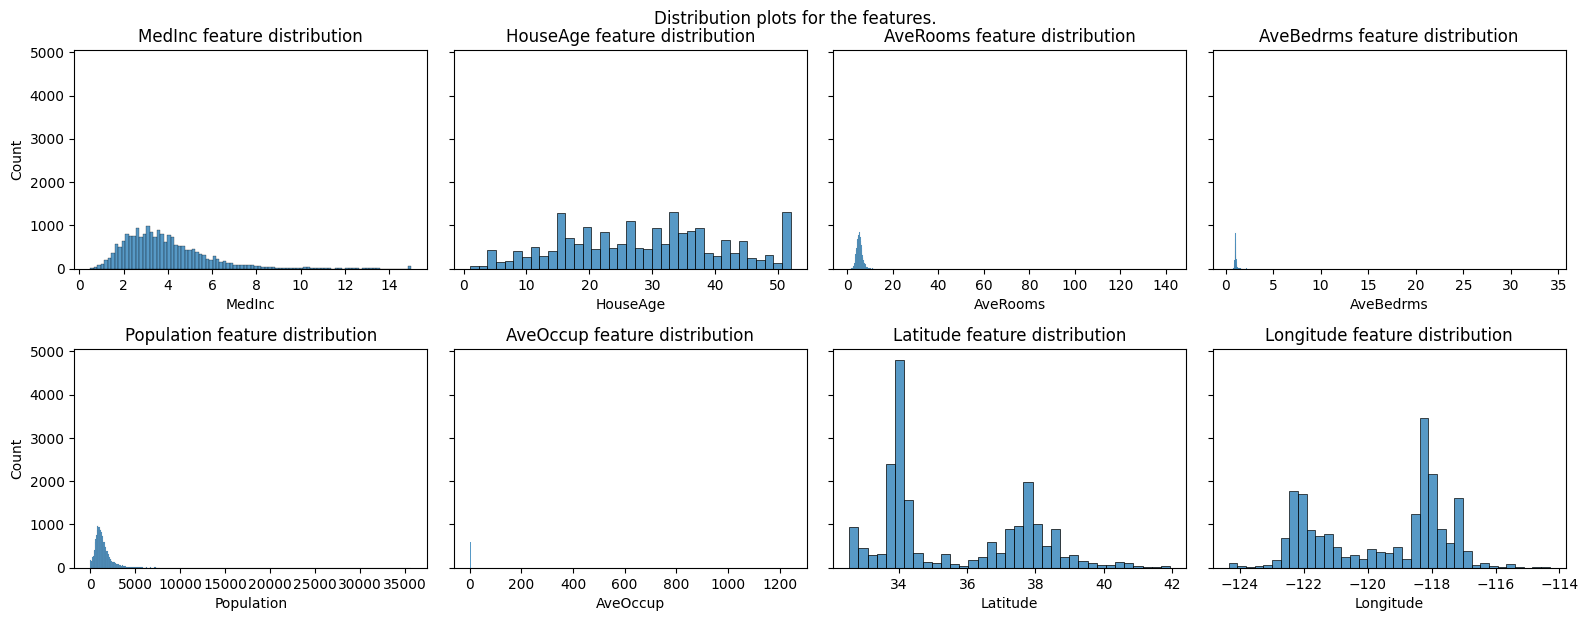

In [5]:
"""
I used ChatGPT 5 to generate the distribution_grid_seaborn function on 2-Sep-2025 9:03 PM and amended it.
"""


def distribution_grid_seaborn(df, x_cols, rows=5, cols=4, suptitle=None):
    n = min(len(x_cols), rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey=True)
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < n:
            x = x_cols[i]
            sns.histplot(data=df, x=df[x_cols[i]], ax=ax)
            ax.set_title(f"{x} feature distribution")
            if i % cols == 0:  # only leftmost plots get y-label
                ax.set_ylabel("Count")
            else:
                ax.set_ylabel("")
            ax.set_xlabel(x)
        else:
            ax.set_visible(False)

    if suptitle:
        fig.suptitle(suptitle, y=0.98)
    plt.tight_layout()
    plt.show()


X = data.drop(columns=["MedHouseVal"])
y = data["MedHouseVal"]

distribution_grid_seaborn(
    X,
    X.columns.tolist(),
    suptitle="Distribution plots for the features.",
)

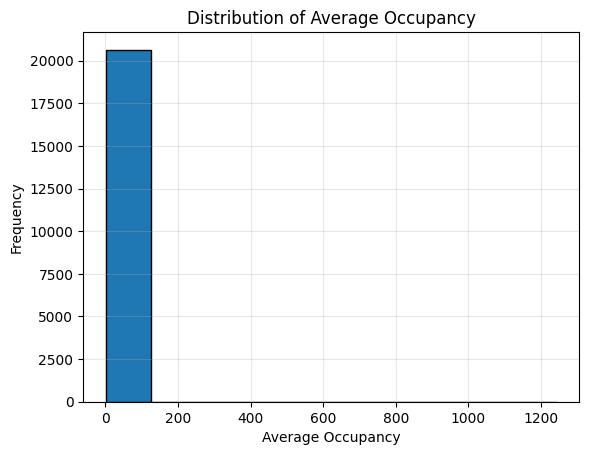

In [6]:
data["AveOccup"].hist(bins=10, edgecolor="k")
plt.xlabel("Average Occupancy")
plt.ylabel("Frequency")
plt.title("Distribution of Average Occupancy")
plt.grid(visible="y", alpha=0.3)
plt.show()

In [7]:
print(
    data["AveOccup"].max(),
    data["AveOccup"].min(),
    data["AveOccup"].mean(),
    data["AveOccup"].median(),
)
print(data["AveOccup"].describe())
data[data["AveOccup"] > 20]

1243.3333333333333 0.6923076923076923 3.0706551594363742 2.818115654360196
count    20640.000000
mean         3.070655
std         10.386050
min          0.692308
25%          2.429741
50%          2.818116
75%          3.282261
max       1243.333333
Name: AveOccup, dtype: float64


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.67500
5986,1.8750,52.0,4.500000,1.206349,2688.0,21.333333,34.10,-117.71,2.12500
8874,9.3370,52.0,7.285714,1.214286,1154.0,41.214286,34.06,-118.45,5.00001
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.54600
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.62500
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.25000
13366,4.2578,36.0,5.258824,1.117647,2886.0,33.952941,33.94,-117.63,1.83300
16420,5.7485,26.0,5.366667,0.900000,1542.0,51.400000,37.89,-121.29,1.62500
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70,3.50000
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.37500


### Dropping outliers in the Average Occupancy and Average Rooms features due to unrealistic values.

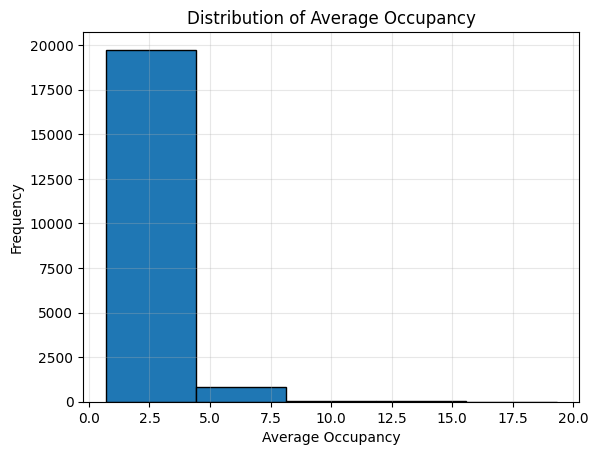

In [8]:
data = data[(data["AveOccup"] < 20) & (data["AveRooms"] < 100)]

X = data.drop(columns=["MedHouseVal"])
y = data["MedHouseVal"]

disp = data["AveOccup"].hist(bins=5, edgecolor="k")
plt.xlabel("Average Occupancy")
plt.ylabel("Frequency")
plt.title("Distribution of Average Occupancy")
plt.grid(visible="y", alpha=0.3)
plt.show()

### Model Training and Evaluation

In [9]:
# --- Train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# --- Model
rf = RandomForestRegressor(n_estimators=300, random_state=7)
rf.fit(X_train, y_train)

# --- Predictions
y_pred = rf.predict(X_test)

print("Model performance on the test set:")
print(
    "R^2 Score:",
    r2_score(y_test, y_pred),
)
print(
    "Mean Abasolute Error:",
    mean_absolute_error(y_test, y_pred),
)

Model performance on the test set:
R^2 Score: 0.8213913364807963
Mean Abasolute Error: 0.32070446303118466


### Checking the distribution of residuals to see if they are normally distributed.

<Axes: xlabel='MedHouseVal', ylabel='Count'>

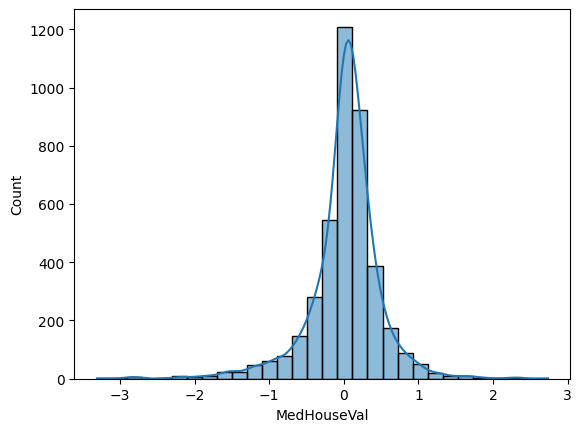

In [10]:
sns.histplot(y_pred - y_test, bins=30, kde=True)

### Exploratory Data Analysis with Pearson & Spearman correlations

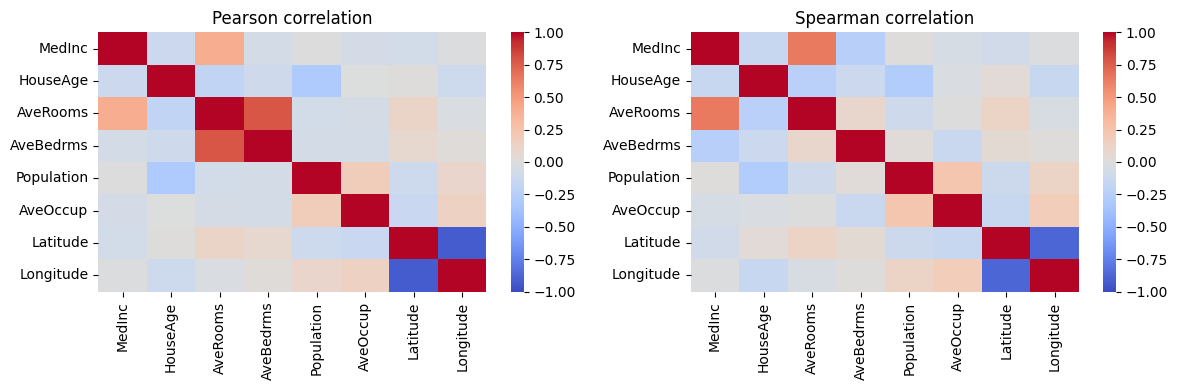

In [11]:
corr_p = X_train.corr(method="pearson")
corr_s = X_train.corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(corr_p, ax=axes[0], vmin=-1, vmax=1, annot=False, cmap="coolwarm")
axes[0].set_title("Pearson correlation")
sns.heatmap(corr_s, ax=axes[1], vmin=-1, vmax=1, annot=False, cmap="coolwarm")
axes[1].set_title("Spearman correlation")
plt.tight_layout()
plt.show()

### Feature importance

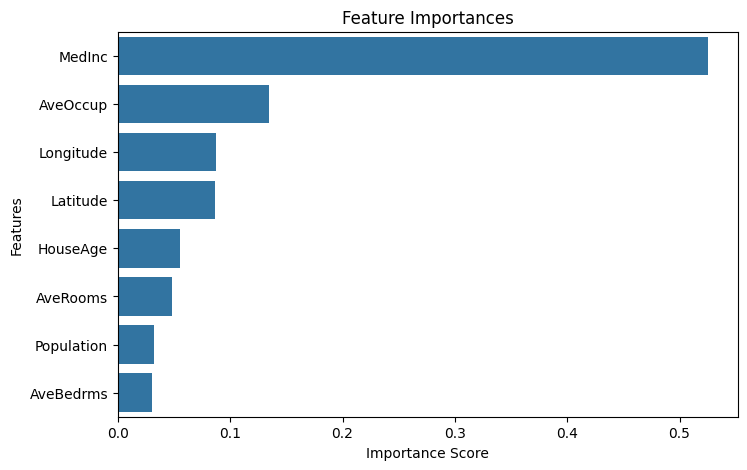

In [12]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(
    ascending=False
)
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

### PDP and ICE plots

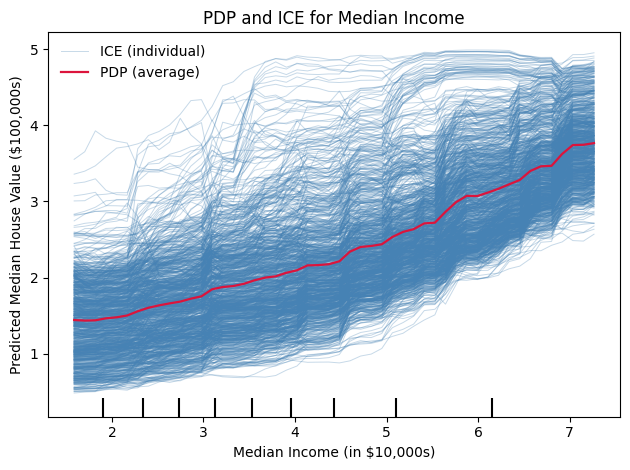

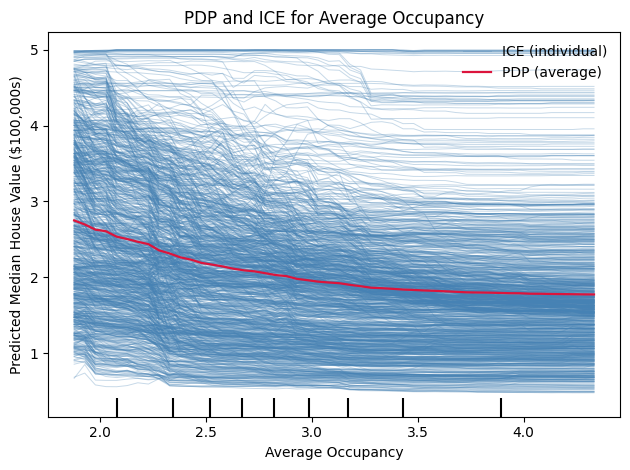

In [13]:
"""
I used ChatGPT 5 to generate the PDP and ICE plot overlays on 28-Sep-2025 12:30 PM and amended it.
"""

# --- Choose features (watch correlation—e.g., MedInc, AveOccup, Latitude)
features = {"MedInc": "Median Income", "AveOccup": "Average Occupancy"}

pdp_style = dict(color="crimson", linestyle="-", linewidth=1.6)
ice_style = dict(color="steelblue", alpha=0.3, linewidth=0.7)

for f in features.keys():
    PartialDependenceDisplay.from_estimator(
        rf,
        X_train,
        [f],
        kind="both",  # PDP + ICE
        grid_resolution=50,
        random_state=7,
        line_kw=pdp_style,  # PDP styling
        ice_lines_kw=ice_style,  # ICE styling
    )

    plt.title(f"PDP and ICE for {features[f]}")
    plt.ylabel("Predicted Median House Value ($100,000s)")
    if f == "MedInc":
        plt.xlabel(f"{features[f]} (in $10,000s)")
    else:
        plt.xlabel(f"{features[f]}")

    # add a clean legend
    plt.legend(
        handles=[
            Line2D([], [], **{**ice_style, "label": "ICE (individual)"}),
            Line2D([], [], **{**pdp_style, "label": "PDP (average)"}),
        ],
        loc="best",
        frameon=False,
    )
    plt.tight_layout()
    plt.show()

### ALE plots

INFO:PyALE._ALE_generic:Continuous feature detected.


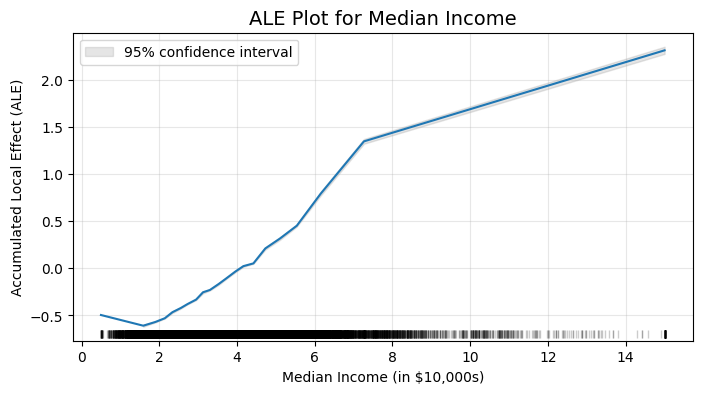

INFO:PyALE._ALE_generic:Continuous feature detected.


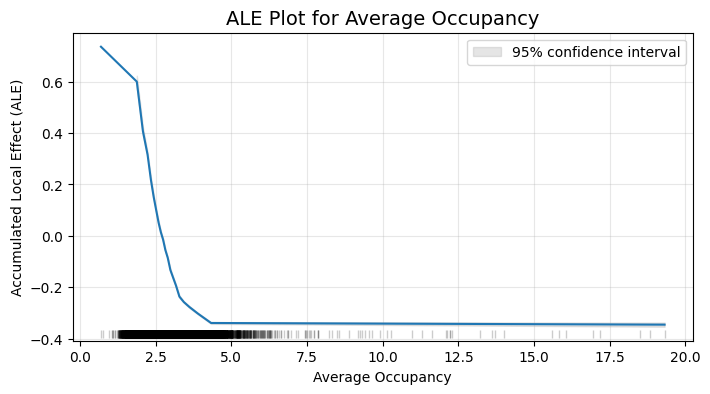

In [14]:
"""
I used ChatGPT 5 to generate the ALE plots on 28-Sep-2025 12:50 PM and amended it.
"""


# Wrapper class so PyALE sees a predict() method
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict(X)


rf_wrapper = ModelWrapper(rf)

# Now use the wrapper in ale()
features = {"MedInc": "Median Income", "AveOccup": "Average Occupancy"}

for f in features.keys():
    ale(
        X=X_train,
        model=rf_wrapper,
        feature=[f],
        grid_size=20,
        include_CI=True,
        plot=True,
    )
    plt.title(f"ALE Plot for {features[f]}", fontsize=14)
    if f == "MedInc":
        plt.xlabel(f"{features[f]} (in $10,000s)")
    else:
        plt.xlabel(f"{features[f]}")
    plt.ylabel("Accumulated Local Effect (ALE)")
    plt.grid(alpha=0.3)
    plt.show()

### Checking for interaction between location and median income

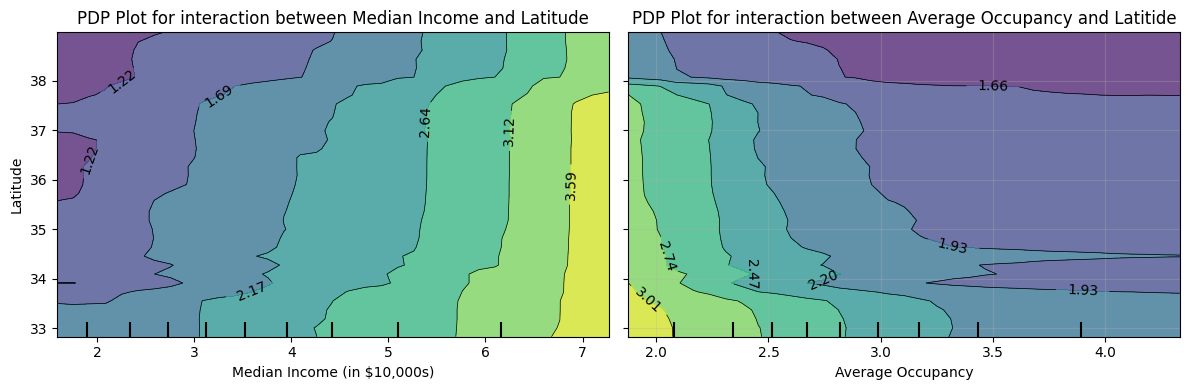

In [15]:
"""
I used ChatGPT 5 to generate the interaction plot on 28-Sep-2025 8:51 PM and amended it.
"""

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

disp = PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    [("MedInc", "Latitude")],
    grid_resolution=35,
    kind="average",
    random_state=7,
    ax=axes[0],
)
disp.axes_[0, 0].set_xlabel("Median Income (in $10,000s)")

disp = PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    [("AveOccup", "Latitude")],
    grid_resolution=35,
    kind="average",
    random_state=7,
    ax=axes[1],
)
disp.axes_[0, 0].set_xlabel("Average Occupancy")
disp.axes_[0, 0].set_ylabel("")
disp.axes_[0, 0].set_yticklabels([])


axes[0].set_title(f"PDP Plot for interaction between Median Income and Latitude")
axes[1].set_title(f"PDP Plot for interaction between Average Occupancy and Latitide")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Explanation of the plots

#### 1 Feature selection for interpretation    
I chose MedInc (median income) and AveOccup (average occupancy) because:     
- MedInc is the most important feature by far (feature importance approximately 0.52).     
- AveOccup is second most important (approximately 0.14) and has a clear, interpretable meaning (crowding).      
- These two have low correlation with each other (approximately -0.06), so their effects can be more cleanly separated. This matters for PDP, which assumes feature independence.      
- Both have reasonable distributions without extreme outliers (after filtering AveOccup < 20).     

PDP and ICE (global average and individual behavior)     

#### 2 MedInc (Median Income)            
The PDP of the median income shows a clean, monotonic increase in predicted house value with a small saturation at the very high end afer \$70,000. The ICE spread is relatively tight and mostly parallel, which is a consistent positive effect across tracts with a little interaction.         
In general, as median income rises, the model’s predicted house value increases for nearly everyone. However, there is some diminishing returns at high incomes with increasing income not causing associated increase in house value.    

AveOccup (Average Occupancy)             
The PDP shows a declining trend that flattens around approximately 3.5 to 4.5 occupants per household. The ICE spread is wider than what we got for median income, indicating some heterogeneous effect and in some cases, average occupancy has no effect. Thus, the average occupancy's effect on the predicted house value depends on the neighborhood context.        
In general, higher occupancy or crowding per household generally reduces the predicted value, with most of the drop between approximately 2 and 3.5 occupants. Beyond approximately 3.5 occupants, the effect of average occupancy on the predicted house values is insignificant.         

#### 3 ALE (local and correlation resistant effects)        
Since ALE is robust against correlating variables and outliers, it’s the more reliable read in these conditions and I'll be comparing its results with that of the PDP and ICE.

MedInc (Median Income)            
Here again, median income has a monotonic, strongly positive effect on the house value. There is a slight negative effect before approximately `$15,000` which suggests that as median household income rose in households with very low median household income the house value actually reduced. As income doubled from `$20,000` to `$40,000`, the model’s predicted median house value rises by approximately 0.5 on the ALE scale (`$50 000` in real terms), relative to the global mean prediction. It continues the steep rise until approximately `$75,000` median household income, where the rise becomes more linear with a gentler slope. The Rug plot shows that most data lie between approximately `$20,000` and `$80,000`, with few very low or very high-income tracts. This could explain the more linear rise at the high end, as there is less data to inform the model.

In conclusion, even after accounting for correlations, income is the primary local driver of higher predicted house value.

AveOccup (Average Occupancy)             
This has a steep drop from approximately 1.5 to 2.5 and continues to approximately 4.5, then it practically gets a flat plateau, with a very small drop for larger values. The rug plot shows that most data lie between approximately 2 and 6 persons per household.           
In conclusion, generally, crowding negatively affects house value, reducing the predicted value up to about 4 occupants. Beyond this, additional occupants don't change the house values very much. ALE also down-weights any unrealistic extremes that can distort PDP so this shows a realistic picture.         

#### 4 Conclusion           
There is consistency in the results of the PDP, ICE and ALE. All three agree on direction for both features, where median household income has a positive effect on house values and average household occupancy has a negative effect on the predicted house values. The interaction PDP plot between median income and latitude shows that the effect of median income on house value is stronger in the southern part of California (lower latitudes). This could be due to the higher cost of living in southern California, where higher income has a greater impact on house prices.     

The ICE plot for average occupancy shows some heterogeneity as it fans out more than it does for MedInc, signaling interactions. Crowding matters more in some contexts, tied to location of the house as seen in the interaction between average occupancy and latitude. The non-parallel lines in the PDP plot suggests interaction effects.

In summary:
1. Median Income is a strong, monotonic positive driver of predicted house values and robust to correlation.
1. Average Occupancy has a localized negative effect (crowding), strongest from approximately 1.5 to 4.5 occupants and largely flat afterward.
1. Geography matters moderately and likely interacts with both, especially average occupancy, as seen in the interaction PDP plots with latitude.
